In [1]:
'''Example script to generate text from Nietzsche's writings.
At least 20 epochs are required before the generated text
starts sounding coherent.
It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.
If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''
import tensorflow as tf
import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import urllib
import time
import sys
sys.path.append('git/PRIM/source/')
sys.path.append('git/PRIM/scripts/')

In [2]:
import osmMerger
import CustomUtils

In [3]:
import pandas as pd

In [4]:
def fillNaWithHistoricalValues(df):
    oldIdx = df.columns
    idx=[pd.to_datetime(df.columns.values).date,pd.to_datetime(df.columns.values).time]
    mIdx=pd.MultiIndex.from_arrays(idx,names=['day','time'])
    df.set_axis(mIdx,axis=1,inplace=True)
    df = df.add(df.isna()*df.groupby(by=df.columns.get_level_values(1),axis=1).mean(),fill_value=0)
    df.set_axis(oldIdx,axis=1,inplace=True)
    return df


def dropWeekends(data):
    data.drop(data.columns[[ x.date().weekday()>=5 for x  in data.columns]],axis=1,inplace=True)

In [1514]:
speeds = pd.read_pickle('/home/dsi/mbouchouia/code/speeds1419.pckl')
counts = pd.read_pickle('/home/dsi/mbouchouia/code/counts1419.pckl')

In [1515]:
dropWeekends(speeds)
dropWeekends(counts)

In [1443]:
#mergeResults,segmentsMeta= osmMerger.mergeSegments(minValidData = osmMerger.MIN_VALID_DATA, weights=osmMerger.WEIGHTS,speedsMx=speeds)
# mergeResults.to_pickle("mergeResults.pckl")
# segmentsMeta.to_pickle("segmentsMeta.pckl")

Computing raw data : 
first time call or reset : starting counter
getting segments and meta :
time spent 40.8 s
getting speed matrix :
time spent 0.0 s
computing meta attributs and inversed index :
time spent 0.1 s
computing merging criteria :
time spent 99.2 s
start merging :
iter :  1  seg 1 :  5970  seg2 :  5943  inv seg2 :  5943  mean non null  0.27888044394669614
iter :  101  seg 1 :  3226  seg2 :  3180  inv seg2 :  3180  mean non null  0.28091760251720344
iter :  201  seg 1 :  5110  seg2 :  5115  inv seg2 :  5115  mean non null  0.2842863645230509
iter :  301  seg 1 :  3408  seg2 :  3409  inv seg2 :  3409  mean non null  0.28818379007512435
iter :  401  seg 1 :  1803  seg2 :  1800  inv seg2 :  1800  mean non null  0.29245569892762474
iter :  501  seg 1 :  5615  seg2 :  5614  inv seg2 :  5614  mean non null  0.2970238339699098
iter :  601  seg 1 :  1886  seg2 :  1888  inv seg2 :  1888  mean non null  0.3017332423056024
iter :  701  seg 1 :  489  seg2 :  487  inv seg2 :  487  mean 

In [1437]:
mergeResults=pd.read_pickle("mergeResults.pckl")
segmentsMeta=pd.read_pickle("segmentsMeta.pckl")

In [1444]:
mergedIndex=pd.Series(data=segmentsMeta.loc[mergeResults]['segmentID'].values,index = segmentsMeta['segmentID'].values)

In [1445]:
updatedSpeed = speeds.assign(newIndex =mergedIndex.reindex(speeds.index).values)
updatedSpeed = updatedSpeed[~updatedSpeed.newIndex.isna()]
updatedSpeed.groupby('newIndex').mean().to_pickle("rawUpdatedSpeed1419.pckl")
updatedSpeed=updatedSpeed.groupby('newIndex').mean().dropna(thresh = int(0.8*len(updatedSpeed.columns)))
updatedSpeed.to_pickle("updatedSpeed1419.pckl")
updatedSpeed=fillNaWithHistoricalValues(updatedSpeed)
updatedSpeed.to_pickle("updatedSpeedWithHistoricalValues1419.pckl")

In [11]:
rawSpeed= fillNaWithHistoricalValues(speeds.groupby('matching_road').mean().dropna(thresh = int(0.8*len(speeds.columns))))

In [1517]:
def getExamples(sequence,inputLag,outputLag):
    sequenceLength=len(sequence)
    subSequenceLength = inputLag+outputLag
    if subSequenceLength > sequenceLength :
        raise ValueError("sequence length {} too small for lags : {},{}".format(sequenceLength,inputLag,outputLag))
    return [sequence[i:i+inputLag] for i in range(0,sequenceLength-subSequenceLength+1,1)],[sequence[i+inputLag:i+inputLag+outputLag] for i in range(0,sequenceLength-subSequenceLength+1,1)]

In [1518]:
def getXY(data, inputLag, outputLag, sequenceLength):
    nsegs,ntime=data.shape
    if(ntime%sequenceLength)!= 0 :
        raise ValueError("sequence length {} not compatible with number of time features {}".format(sequenceLength,ntime))
        
    shapedData = data.values.T.reshape(int(ntime/sequenceLength),sequenceLength,nsegs)
    
    examples=[getExamples(x,inputLag,outputLag) for x in shapedData]
    x,y = list(zip(*examples))
    return np.concatenate(x),np.concatenate(y)

In [1519]:
def getIndexes(idx,data, inputLag, outputLag, sequenceLength):
    cx,cy= (idx +(inputLag+outputLag-1)*(idx//(sequenceLength - inputLag-outputLag+1)), idx +(inputLag+outputLag-1)*(idx//(sequenceLength - inputLag-outputLag+1))+inputLag )
    return (data.columns[cx:cy].values,data.columns[cy:cy+outputLag].values)

In [1520]:
def getPairDistance(data,segmentsMeta):
    locs= segmentsMeta.set_index('segmentID').loc[data.index]['loc'].apply(lambda x : x['coordinates'][len(x['coordinates'])//2] )
    return np.fromiter([CustomUtils.reverseVincenty(x,y) for x in locs for y in locs],dtype=float).reshape((len(locs),len(locs)))
dists = getPairDistance(fullSegs,segmentsMeta)

In [1553]:
fullSegs=speeds.groupby('matching_road').mean().dropna()

In [1521]:
TRANSFORM=False


In [1522]:
if TRANSFORM :
    data = fullSegs.copy().transform(np.log1p)
else :
    data = fullSegs.copy()


In [1523]:
nSegments = len(data)

In [1525]:
inputLag, outputLag, sequenceLength=1,1,20

In [1526]:
x,y=getXY(data,inputLag, outputLag, sequenceLength)
MUL=1

In [1527]:
MUL=130
x/=130
y/=130

In [1528]:
x.shape,y.shape

((247, 1, 114), (247, 1, 114))

In [ ]:
# tensorborad callbacks
tfBoard=tf.keras.callbacks.TensorBoard(log_dir='./tflogs/'+time.ctime(), histogram_freq=10,write_grads=True,  
          write_graph=True, write_images=True)

In [1529]:
# simple MLP model
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
#layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(nSegments))
model.add(tf.keras.layers.Dense(nSegments))
model.add(tf.keras.layers.Dense(nSegments))

optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)

In [1531]:
valid_split=0.5
model.fit(x,y.reshape(-1,nSegments), batch_size=1, epochs=100, validation_split=valid_split,verbose=1)#,callbacks=[tfBoard])

Train on 123 samples, validate on 124 samples
Epoch 1/100
 - 0s - loss: 0.0059 - val_loss: 0.0084
Epoch 2/100
 - 0s - loss: 0.0056 - val_loss: 0.0091
Epoch 3/100
 - 0s - loss: 0.0052 - val_loss: 0.0079
Epoch 4/100
 - 0s - loss: 0.0065 - val_loss: 0.0086
Epoch 5/100
 - 0s - loss: 0.0067 - val_loss: 0.0100
Epoch 6/100
 - 0s - loss: 0.0065 - val_loss: 0.0094
Epoch 7/100
 - 0s - loss: 0.0061 - val_loss: 0.0087
Epoch 8/100
 - 0s - loss: 0.0057 - val_loss: 0.0080
Epoch 9/100
 - 0s - loss: 0.0058 - val_loss: 0.0094
Epoch 10/100
 - 0s - loss: 0.0054 - val_loss: 0.0082
Epoch 11/100
 - 0s - loss: 0.0062 - val_loss: 0.0095
Epoch 12/100
 - 0s - loss: 0.0060 - val_loss: 0.0078
Epoch 13/100
 - 0s - loss: 0.0059 - val_loss: 0.0079
Epoch 14/100
 - 0s - loss: 0.0056 - val_loss: 0.0082
Epoch 15/100
 - 0s - loss: 0.0062 - val_loss: 0.0089
Epoch 16/100
 - 0s - loss: 0.0059 - val_loss: 0.0083
Epoch 17/100
 - 0s - loss: 0.0055 - val_loss: 0.0077
Epoch 18/100
 - 0s - loss: 0.0053 - val_loss: 0.0090
Epoch 19/

In [1554]:
# weights shapes
[x.shape for x in model.get_weights()]


[(114, 114), (114,), (114, 114), (114,), (114, 114), (114,)]

In [1533]:
def getPred(x,y,i,mul=1,idx=-1,transform = False,model=model):
    if transform :
        xs=pd.DataFrame(x[i]).T.transform(np.expm1)
        pred = np.expm1(model.predict(x[i:i+1]).flatten())
        ys=np.expm1(y[i:i+1].flatten())
    else : 
        xs=pd.DataFrame(x[i]).T
        pred = model.predict(x[i:i+1]).flatten() 
        ys=y[i:i+1].flatten()
    predsDF=pd.concat([xs,pd.DataFrame([pred,ys ,pred-ys],index=["pred","y",'pred - y']).T],axis=1)
    if idx>-1:
        return (predsDF.sort_values("pred - y")*mul).loc[idx]
    return predsDF.sort_values("pred - y")*mul

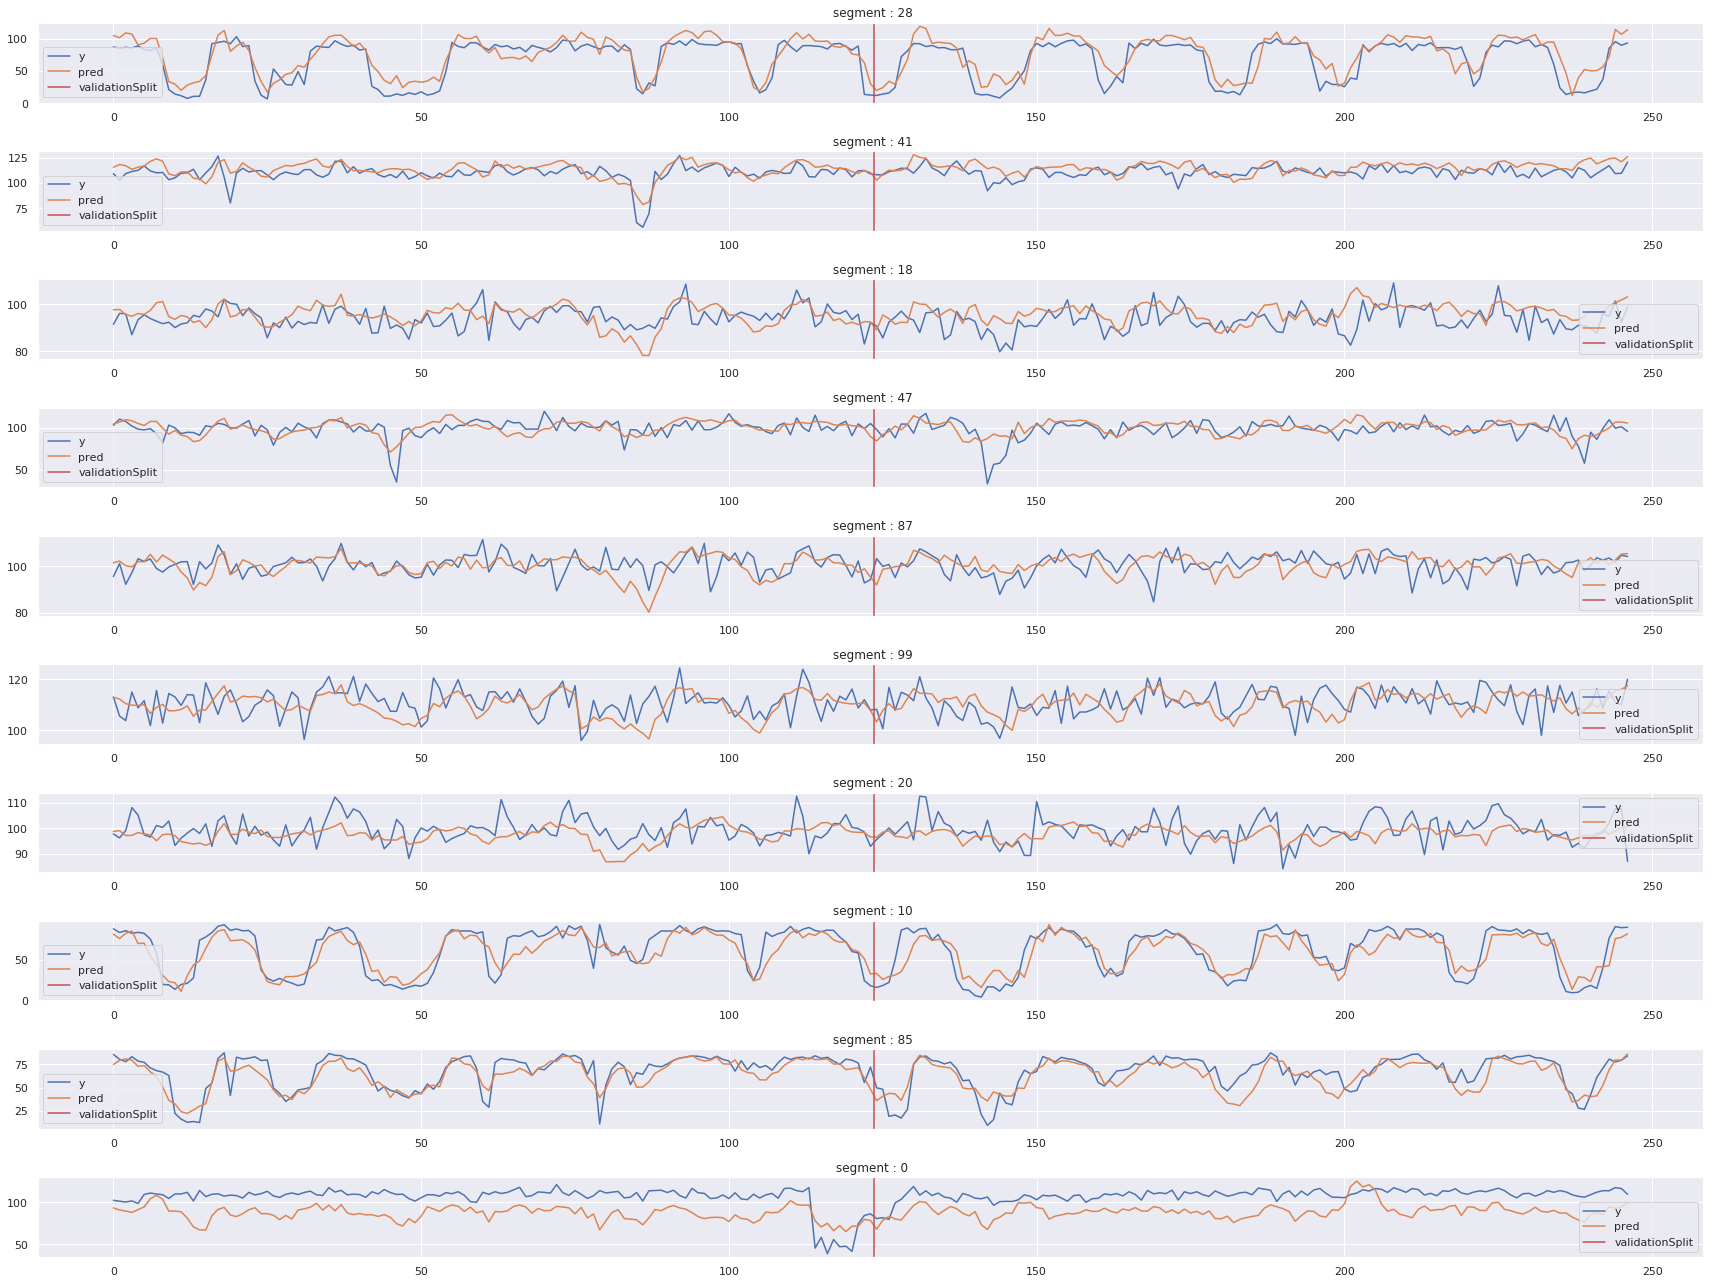

In [1555]:
samplePred = np.argsort(y.mean(axis=0)[0]-model.predict(x).mean(axis=0))[np.r_[:nSegments-1:10j].astype(int)]

plt.figure(figsize=(24,18))

for ix, xSample in enumerate(samplePred):
    plt.subplot(len(samplePred),1,ix+1)
    preds = pd.concat([getPred(x,y,i,idx=xSample,mul=MUL) for i in range(len(x))],axis=1).T
    plt.plot(preds['y'].values)
    plt.plot(preds['pred'].values)
    plt.axvline((1-valid_split)*x.shape[0],c='r')
    plt.legend(['y','pred','validationSplit'])
    plt.title(" segment : {}".format(xSample))
plt.tight_layout()
# preds = pd.concat([getPred(x,y,i,idx=30,mul=MUL) for i in range(len(x))],axis=1).T
# plt.figure(figsize=(18,4))
# plt.plot(preds['y'].values)
# plt.plot(preds['pred'].values)
# plt.axvline(0.75*x.shape[0],c='r')
# plt.legend(['y','pred','validationSplit'])